In [2]:
import pandas as pd

data = pd.read_csv("D:/Downloads/creditcard.csv/creditcard.csv")
print(data.head())
print(data.info())
print(data.describe())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

<AxesSubplot:xlabel='Class', ylabel='count'>

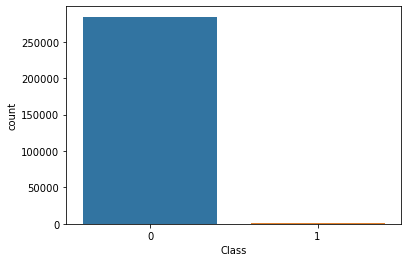

In [3]:
import seaborn as sns
sns.countplot(x='Class', data=data)


Text(0.5, 1.0, 'Time Distribution')

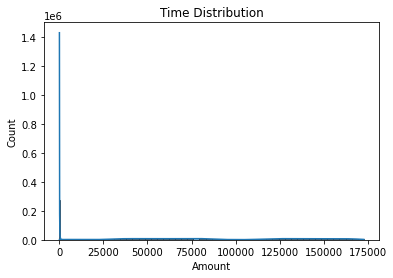

In [4]:
sns.histplot(data['Amount'], bins=50, kde=True).set_title('Amount Distribution')
sns.histplot(data['Time'], bins=50, kde=True).set_title('Time Distribution')

In [5]:
# Pre-processing
# Step 2

from sklearn.preprocessing import StandardScaler

data['Scaled_Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Scaled_Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data = data.drop(['Amount', 'Time'], axis=1)


In [6]:
X = data.drop('Class', axis=1)  # Features: Scaled_Time, Scaled_Amount, V1-V28
y = data['Class']  # Target variable

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [10]:
%pip install imbalanced-learn


  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [9]:
# Define the model
# Step 3

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_sm.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


In [10]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train_sm, y_train_sm, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
11373/11373 [==============================] - 12s 972us/step - loss: 0.0371 - accuracy: 0.9869 - val_loss: 0.0065 - val_accuracy: 0.9993
Epoch 2/20
11373/11373 [==============================] - 11s 990us/step - loss: 0.0101 - accuracy: 0.9973 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 3/20
11373/11373 [==============================] - 11s 993us/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/20
11373/11373 [==============================] - 11s 955us/step - loss: 0.0061 - accuracy: 0.9986 - val_loss: 9.6904e-04 - val_accuracy: 1.0000
Epoch 5/20
11373/11373 [==============================] - 11s 995us/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0024 - val_accuracy: 0.9996
Epoch 6/20
11373/11373 [==============================] - 11s 981us/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 4.2936e-04 - val_accuracy: 1.0000
Epoch 7/20
11373/11373 [==============================] - 11s 953us/step - loss: 0.0045 - accuracy

In [12]:
# Evaluate the model
# Step 4

# Performance metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


1781/1781 [==============================] - 1s 567us/step
[[56827    37]
 [   18    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.68      0.82      0.74        98

    accuracy                           1.00     56962
   macro avg       0.84      0.91      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [13]:
# AUPRC calculation

y_prob = model.predict(X_test).ravel()
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc}")


1781/1781 [==============================] - 1s 529us/step
AUPRC: 0.7906022044188139


Text(0.5, 1.0, 'Loss Curves')

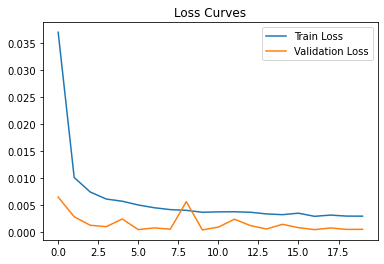

In [14]:
# Visualizations
# Step 5

import matplotlib.pyplot as plt

# Loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
